In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import copy

import seaborn as sns
from matplotlib import pyplot as plt

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

# from google.colab import drive
# drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

GPU: False


In [2]:
# train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_train.csv")

train = pd.read_csv(r"../datasets/fashion-mnist_train.csv")

label_dict = {0:'top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle'}

class_num = 10

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

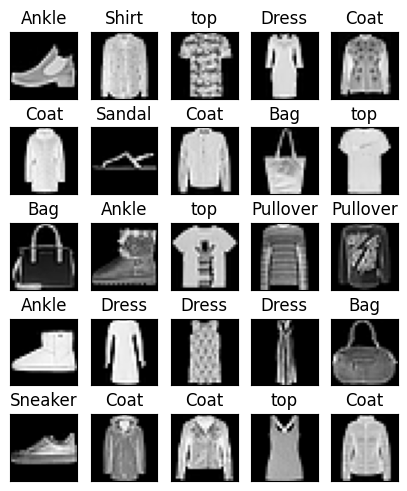

In [4]:
r = 5
c = 5
fig=plt.figure(figsize=(r, c*1.2), dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(label_dict[Y[i]])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [6]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [7]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=1000)
val = DataLoader(val,batch_size=1000)

In [8]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,100)
        self.linear3 = nn.Linear(100,64)
        self.linear4 = nn.Linear(64,10)
    
    def forward(self,X):
        X1 = F.relu(self.linear1(X))
        X2 = F.relu(self.linear2(X1))
        X3 = F.relu(self.linear3(X2))
        X4 = self.linear4(X3)
        return X1, X2, X3, F.log_softmax(X4, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()
    
print(mlp)    

Model(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [11]:
def compute_val_loss(val_x,val_y,model):
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)[3]
    loss = F.cross_entropy(output,val_y)
    return loss

In [12]:
%%time
EPOCHS = 10

trn_loss = []
val_loss = []

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
        
        _, _, _, y_pred = mlp(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,mlp)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.6819925904273987 | val_loss: 0.7219535112380981
Epoch: 2 | loss: 0.5168856382369995 | val_loss: 0.5594692230224609
Epoch: 3 | loss: 0.4442238509654999 | val_loss: 0.49430835247039795
Epoch: 4 | loss: 0.4111034572124481 | val_loss: 0.45134517550468445
Epoch: 5 | loss: 0.3888566195964813 | val_loss: 0.42915815114974976
Epoch: 6 | loss: 0.3751465380191803 | val_loss: 0.41597071290016174
Epoch: 7 | loss: 0.3564853072166443 | val_loss: 0.40602371096611023
Epoch: 8 | loss: 0.34020137786865234 | val_loss: 0.4001035988330841
Epoch: 9 | loss: 0.3301393389701843 | val_loss: 0.40500757098197937
Epoch: 10 | loss: 0.32527488470077515 | val_loss: 0.4021611213684082
CPU times: total: 2min 39s
Wall time: 34 s


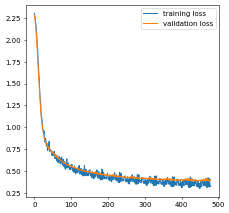

In [13]:
plt.figure(figsize=(5,5),dpi=50)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [14]:
def predict(model,val_x,ret_fm=False):
    """
    ret_fm: when set True, return feature map of layers
    """
    if cuda: val_x = val_x.cuda()
    out = model(val_x)
   
    ret = []
    y_preds = []
    if(ret_fm == False):
        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
        
        ret = y_preds
    else:
        f1 = out[0].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 256
        f2 = out[1].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 100
        f3 = out[2].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 64

        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
            
        ret = (f1, f2, f3, y_preds)
    
    return ret

In [15]:
pred = predict(mlp,val_x)

Accuracy: 85.73333333333333 %


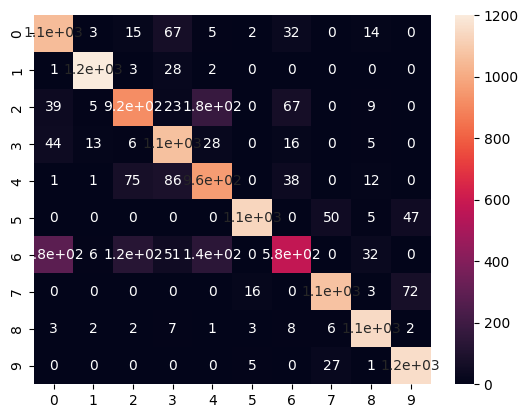

In [16]:
cm = confusion_matrix(val_y.numpy(), pred)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),pred)*100,"%")

tensor(1)


Text(0.5, 1.0, 'fm of layer2')

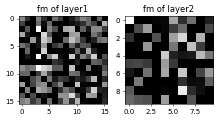

In [17]:
sp1 = val_x[0, :].reshape(1,-1)   # take one sample from validation set [1, 784]

res1 = predict(mlp,sp1,ret_fm=True)   # then make a prediction

print(val_y[0])  # true lable of the sample

plt.figure(figsize=(5, 3), dpi=50)
plt.subplot(121)
plt.imshow(res1[0].reshape(16, 16), cmap='gray')
plt.title("fm of layer1")
plt.subplot(122)
plt.imshow(res1[1].reshape(10, 10), cmap='gray')
plt.title("fm of layer2")

In [18]:
# begin testing
pred = predict(mlp, val_x, ret_fm=True)    # return (f1, f2, f3, y_preds)
pred[0].shape, pred[1].shape, pred[2].shape

((12000, 256), (12000, 100), (12000, 64))

Each layer generates either of the two feature maps: 

1. **positive** feature map(on the correctly classified sample)
2. **negative** feature map(on the mis-classified sample)

i.e. for any class $c$ we have:
$$\bar x_{pos,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{pos,c}^{(m)}$$
and
$$\bar x_{neg,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{neg,c}^{(m)}$$

In [19]:
layer_num = len(pred) - 1

In [20]:
target = val_y.numpy()
y_pred = pred[-1]

benchmarks = dict()
for l in range(layer_num):      # for all layers
    benchmarks[l] = {'pos':None, 'neg':None}     # feature map dict {layer0: {pos_dict, neg_dict}, layer1:{},,,}
    
    current_layer_fm = pred[l]                    # size: 12000*256
    pos_dict = dict()               # {'0': (numpy(1*256), t)}  t is the times '0' is visited
    neg_dict = dict()
    for i in range(current_layer_fm.shape[0]):    # for all samples
        if(y_pred[i] == target[i]):
            if target[i] not in pos_dict:   # if the first time
                pos_dict[target[i]] = (current_layer_fm[i], 1)
            else:
                t = pos_dict[target[i]][1]
                pos_dict[target[i]] = (pos_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                pos_dict[target[i]][1] += 1
        else:
            if target[i] not in neg_dict:
                neg_dict[target[i]] = (current_layer_fm[i], 1)
            else:
                t = neg_dict[target[i]][1]
                neg_dict[target[i]] = (neg_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                neg_dict[target[i]][1] += 1
    
    benchmarks[l]['pos'] = pos_dict
    benchmarks[l]['neg'] = neg_dict

In [21]:
def distance(benchmark, feature_map, method='L2', norm=True):
    """
    calculate the similarity between benchmark and a feature map
    """

    benchmark = benchmark.reshape(-1, 1)
    feature_map = feature_map.reshape(-1, 1)

    if norm is True:
        scaler = StandardScaler()
        benchmark = scaler.fit_transform(benchmark)
        feature_map = scaler.fit_transform(feature_map)

    if method == 'L2':
        return np.linalg.norm(benchmark - feature_map)
    
    raise Exception("No designated method found.")

class 0, layer 0, sim: 0.240795
class 0, layer 1, sim: 0.439755
class 0, layer 2, sim: 0.464002
class 1, layer 0, sim: 0.083088
class 1, layer 1, sim: 0.179898
class 1, layer 2, sim: 0.218160
class 2, layer 0, sim: 0.146917
class 2, layer 1, sim: 0.229338
class 2, layer 2, sim: 0.271744
class 3, layer 0, sim: 0.111867
class 3, layer 1, sim: 0.189701
class 3, layer 2, sim: 0.259430
class 4, layer 0, sim: 0.080877
class 4, layer 1, sim: 0.165675
class 4, layer 2, sim: 0.229040
class 5, layer 0, sim: 0.067424
class 5, layer 1, sim: 0.174356
class 5, layer 2, sim: 0.252100
class 6, layer 0, sim: 0.129931
class 6, layer 1, sim: 0.289213
class 6, layer 2, sim: 0.417479
class 7, layer 0, sim: 0.093967
class 7, layer 1, sim: 0.194510


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18328\2901020284.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 1), dpi=50)


class 7, layer 2, sim: 0.261767
class 8, layer 0, sim: 0.084514
class 8, layer 1, sim: 0.124726
class 8, layer 2, sim: 0.127705
class 9, layer 0, sim: 0.136619
class 9, layer 1, sim: 0.221279
class 9, layer 2, sim: 0.257288


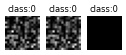

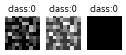

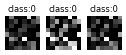

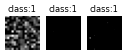

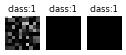

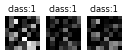

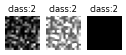

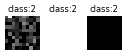

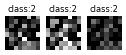

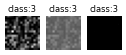

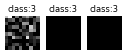

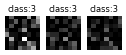

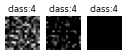

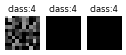

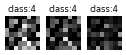

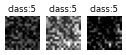

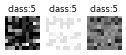

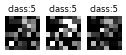

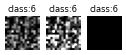

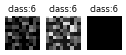

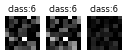

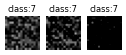

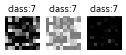

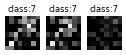

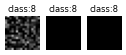

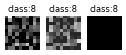

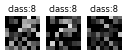

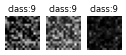

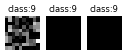

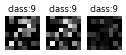

In [22]:
for c in range(class_num):
    for l in range(layer_num):
        fig = plt.figure(figsize=(3, 1), dpi=50)

        pos_bm = benchmarks[l]['pos'][c]
        neg_bm = benchmarks[l]['neg'][c]

        pos_bm = pos_bm.reshape(int(np.sqrt(len(pos_bm))), -1)
        neg_bm = neg_bm.reshape(int(np.sqrt(len(neg_bm))), -1)
        diff_bm = np.abs(np.subtract(pos_bm, neg_bm))

        imgs = [pos_bm, neg_bm, diff_bm]

        sim = 1 / distance(pos_bm, neg_bm, 'L2')

        for i, img in enumerate(imgs):
            plt.subplot(1,3,i+1)
            plt.axis('off')
            plt.title('class:' + str(c))
            plt.imshow(img, cmap='gray')
            plt.clim(np.min(pos_bm), np.max(pos_bm))
        
        print('class %d, layer %d, sim: %f' % (c, l, sim))

In [23]:
y_pred_flat = np.array(y_pred).reshape(1, -1)[0]
y_pred_flat

array([1, 2, 3, ..., 1, 6, 5])

In [24]:
val_y

tensor([1, 2, 3,  ..., 1, 6, 5])

- TODO: count similarities on all sample data, find a threshold

In [25]:
# init dict
dsb = dict()    # distribution dict
for l in range(layer_num):
    pos_dict = dict()
    neg_dict = dict()
    for c in np.unique(val_y):
        pos_dict[c] = []
        neg_dict[c] = []
    dsb[l] = {'pos': pos_dict, 'neg': neg_dict}

for i in range(val_x.shape[0]):
    pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)
    y_pred = pred[-1][0]
    target = int(val_y[i].numpy())

    for l in range(layer_num):  # compare on each layer
        bench_fm = benchmarks[l]['pos'][target]    # there're two benchmarks, only take positive one since it's meaningful
        fm = pred[l]

        sim = 1 / distance(bench_fm, fm, method='L2')

        if y_pred == target:
            dsb[l]['pos'][target].append(sim)
        else:
            dsb[l]['neg'][target].append(sim)

CPU times: total: 17.3 s
Wall time: 20.3 s


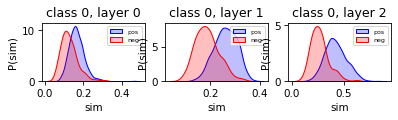

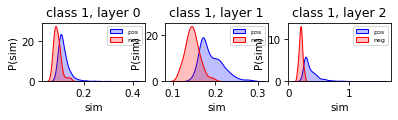

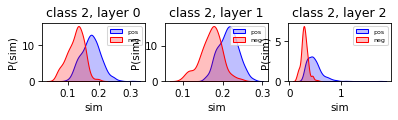

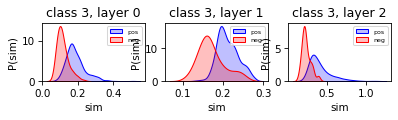

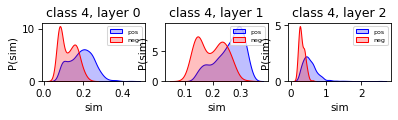

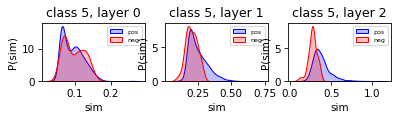

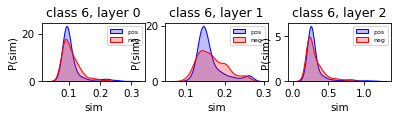

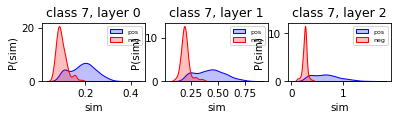

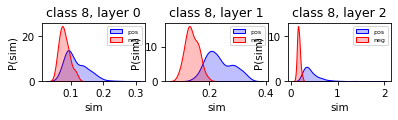

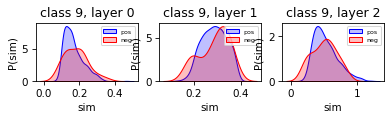

In [26]:
for c in range(class_num):
    fig = plt.figure(figsize=(6, 1), dpi=75)
    for l in range(layer_num):
        
        pos_data = dsb[l]['pos'][c]
        neg_data = dsb[l]['neg'][c]
        
        plt.subplot(1, layer_num, l+1)
        ax = sns.kdeplot(pos_data, color="Blue", fill = True)
        ax = sns.kdeplot(neg_data, ax=ax, color="Red", fill= True)
        ax.legend(["pos","neg"],loc='upper right',prop={'size': 6})
        ax.set_ylabel('P(sim)')
        ax.set_xlabel('sim')
        ax.set_title('class %d, layer %d' % (c, l))

&emsp;&emsp; We can see from the kernel density distribution plots above that for most classes negative samples(red) are subjected to a different distribution from that of the positive samples. They tend to have a lower density.

&emsp;&emsp; Beware, if we change similarity metrics or normalization, the results might be different.

In [27]:
correct_list = [0] * 10
counter_list = [0] * 10
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(val_y[i] == y_pred_flat[i]):
        correct_list[val_y[i]] += 1

for i in range(len(correct_list)):
    print('class %d acc: %f' % (i, correct_list[i] / counter_list[i]))

class 0 acc: 0.884131
class 1 acc: 0.972492
class 2 acc: 0.740920
class 3 acc: 0.905245
class 4 acc: 0.818259
class 5 acc: 0.917342
class 6 acc: 0.476466
class 7 acc: 0.921754
class 8 acc: 0.971211
class 9 acc: 0.972292


Note: Take out those neg samples with large sim -> how are they classified to pos sample?

Note: take 1 neg with very large sim and 1 pos

4 kinds of images: pos+sim, pos-sim, neg+sim, neg-sim

find 5 pics for each

In [28]:
obs_l = 0   # layer in observance
obs_c = 6   # class in observance

Q1_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.25)
Q3_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.75)
Q1_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.25)
Q3_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.75)

imobs_dict = {'pos_Q1': [], 'pos_Q3': [], 'neg_Q1': [], 'neg_Q3': []}
for i in range(val_x.shape[0]):
    if(int(val_y[i]) == obs_c):     # only class in observance will be picked up       
        pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)

        y_pred = pred[-1][0]
        target = obs_c

        fm = pred[obs_l]
        benchmark = benchmarks[obs_l]['pos'][obs_c]
        sim = 1 / distance(benchmark, fm)

        if(y_pred == target):   # pos
            if(sim < Q1_pos and len(imobs_dict['pos_Q1']) < 5):
                imobs_dict['pos_Q1'].append(i)  # put index
            elif(sim > Q3_pos and len(imobs_dict['pos_Q3']) < 5):
                imobs_dict['pos_Q3'].append(i)
        else:
            if(sim < Q1_neg and len(imobs_dict['neg_Q1']) < 5):
                imobs_dict['neg_Q1'].append(i)  # put index
            elif(sim > Q3_neg and len(imobs_dict['neg_Q3']) < 5):
                imobs_dict['neg_Q3'].append(i)
        
        # found 5 imgs for 4 types, exit
        if(len(imobs_dict['pos_Q1']) == 5 and len(imobs_dict['pos_Q3']) == 5 and 
           len(imobs_dict['neg_Q1']) == 5 and len(imobs_dict['neg_Q3']) == 5):
           break

if(len(imobs_dict['pos_Q1']) != 5 or len(imobs_dict['pos_Q3']) != 5 or 
   len(imobs_dict['neg_Q1']) != 5 or len(imobs_dict['neg_Q3']) != 5):
   raise  Exception("Fetch images failed.")

The first row are the images that are classified correctly but have a low similarity with the benchmark of the class.

The second row are the images classified correctly whose similarity is higher than 75% of total samples.

The third row images are misclassified and has a low similarity to benchmark.

The forth row images are misclassified but has a high similarity to benchmark.

The 2nd row looks really eriee... how are these clothes shirts??? They could look like anything(e.g. shirt, coat...) but shirts. NO wonders the network can not gain a high acc..

class 6: Shirt, layer 0


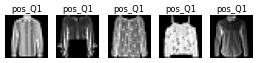

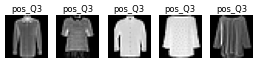

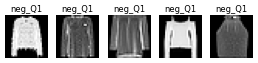

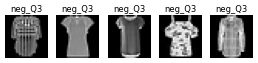

In [29]:
print('class %d: %s, layer %d' % (obs_c, label_dict[obs_c], obs_l))
for key in list(imobs_dict.keys()):
    fig = plt.figure(dpi=50)
    for i, index in enumerate(imobs_dict[key]):
        img = val_x[index].reshape(int(np.sqrt(len(val_x[index]))), -1)
        plt.subplot(1,5,i+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        plt.title(key)

In [30]:
def trace(x, target, benchmarks):
    """
    x: a sample, input image
    target: true label of this sample
    """
    pred = predict(mlp, x, True)
    print("pred label: " + str(pred[-1][0]))

    traces = []
    for l in range(len(pred) - 1):
        fm = pred[l]                    # feature map on current layer
        bms = [benchmarks[l]['pos'][i] for i in range(len(benchmarks[l]['pos']))]
        sims = [round(1 / distance(bm, fm, 'L2'), 6) for bm in bms]
        traces.append(np.argmax(sims))
        print(sims)
    
    return traces

In [31]:
imobs_dict['pos_Q1'], imobs_dict['pos_Q3'], imobs_dict['neg_Q1'], imobs_dict['neg_Q3']

([40, 42, 134, 158, 233],
 [81, 82, 241, 384, 641],
 [4, 189, 289, 290, 340],
 [9, 45, 68, 222, 247])

In [42]:
trace(val_x[42, :].reshape(1,-1), 6, benchmarks)

pred label: 6
[0.056691, 0.05697, 0.117145, 0.049693, 0.09965, 0.055581, 0.057968, 0.051348, 0.067691, 0.052391]
[0.095386, 0.096613, 0.178994, 0.08592, 0.170534, 0.091467, 0.101821, 0.079509, 0.10912, 0.075403]
[0.140704, 0.124917, 0.282694, 0.115827, 0.211825, 0.102642, 0.154694, 0.090251, 0.135753, 0.085316]


[2, 2, 2]

0.06028083717661689


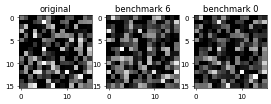

In [44]:
plt.figure(dpi=50)

plt.subplot(1,3,1)
plt.title('original')
plt.imshow(predict(mlp, val_x[42, :].reshape(1,-1), True)[0].reshape(16, 16), cmap='gray')

plt.subplot(1,3,2)
plt.title('benchmark 6')
plt.imshow(benchmarks[0]['pos'][6].reshape(16, 16), cmap='gray')

plt.subplot(1,3,3)
plt.title('benchmark 0')
plt.imshow(benchmarks[0]['pos'][2].reshape(16, 16), cmap='gray')

print(1 / np.linalg.norm(benchmarks[0]['pos'][6] - predict(mlp, val_x[68, :].reshape(1,-1), True)[0]))

Note: improve similarity function and benchmark generation

# Start new from here

<mark>PRINCIPLE: Positive samples and negative samples are subjected to different distribution.</mark>

- get the benchmark feature map (with probabilistic method + a threshold? now the benchmark is mean)
- compare within training samples to calculate 'reliability' (reliability analysis)
- pick top-k reliable layers from $n$ candidates, these k layers are `judge layers`.

---